### Installing dependencies and cloning the database

First install uv, then use it to install dependencies

``` bash
!curl -LsSf https://astral.sh/uv/install.sh | sh
```
Create a new environment and install dependencies
``` bash
!uv venv
!source .venv/bin/activate # on windows use ".venv\Scripts\activate"
!uv pip install -r requirements.txt
```

And then clone the database repo
``` bash
!git clone https://github.com/woct0rdho/pkuholebackup.git
```

In [160]:
import pandas as pd
from scipy.interpolate import make_interp_spline
import numpy as np  # You'll also need numpy for the linspace function
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

### Defining the parsing function

In [139]:

def parse_data(text):
    data = {
        'YEAR': [],
        'DATE': [],
        'TIME': [],
        'ID': [],
        'POST': [],
        'COMMENTS': [],
        'COMMENT_COUNT': []
    }
    
    current_post = None
    current_comments = []
    
    lines = text.strip().split('\n')
    
    i = 0
    while i < len(lines):
        line = lines[i]
        if line.startswith('#p'):
            # If we have a previous post, save it
            if current_post is not None:
                data['YEAR'].append(int(current_post['date'][:4]))
                data['DATE'].append(current_post['date'])
                data['TIME'].append(current_post['time'])
                data['ID'].append(int(current_post['id']))
                data['POST'].append(current_post['content'])
                data['COMMENTS'].append(current_comments)
                data['COMMENT_COUNT'].append(len(current_comments))
            
            # Parse new post
            parts = line.split()
            current_post = {
                'id': parts[1],
                'date': parts[2],
                'time': parts[3],
                'content': ''
            }
            current_comments = []
            
            # Get post content from next line if it exists
            if i + 1 < len(lines) and not lines[i + 1].startswith('#'):
                current_post['content'] = lines[i + 1].strip()
                i += 1  # Skip the content line
            
        elif line.startswith('#c'):
            # Parse comment
            if i + 1 < len(lines):  # Make sure we have a next line
                comment_text = lines[i + 1].strip()  # Get next line for comment content
                current_comments.append(comment_text)
                i += 1  # Skip the comment content line
            
        i += 1
    
    # Don't forget to add the last post
    if current_post is not None:
        data['YEAR'].append(int(current_post['date'][:4]))
        data['DATE'].append(current_post['date'])
        data['TIME'].append(current_post['time'])
        data['ID'].append(int(current_post['id']))
        data['POST'].append(current_post['content'])
        data['COMMENTS'].append(current_comments)
        data['COMMENT_COUNT'].append(len(current_comments))
    # Create DataFrame
    df = pd.DataFrame(data)
    return df

### Importing New Data (2023-2024)

In [140]:
new_df = pd.read_csv('treehole_gsm_2324.csv')

print(new_df.shape)
new_df.head()

(15606, 5)


pid       createtime  reply  length  \
0  5239073  2023/6/30 20:58      0     382   
1  5239164  2023/6/30 21:22     24     159   
2  5239245  2023/6/30 21:43      3      17   
3  5239298  2023/6/30 22:00      3     100   
4  5239302  2023/6/30 22:01      0      11   

                                                text  
0  „ÄêÊãõËÅòÂ≤ó‰Ωç„ÄëÂõΩÊ≥∞ÂêõÂÆâËØÅÂà∏ÊäïËµÑÈì∂Ë°åÈÉ®Êó•Â∏∏ÂÆû‰π†ÁîüÔºàËÇ°ÊùÉÊñπÂêëÔºå‰∏äÊµ∑ÊÄªÈÉ®Ôºâ\n\n„ÄêÂ∑•‰ΩúÂÜÖÂÆπ„Äë\nI...  
1  ÊàñËÆ∏‰ºöÊúâ‰ΩéÂπ¥Á∫ßÂ≠¶ÂºüÂ≠¶Â¶πÊúâÊîπÁÆÄÂéÜÁöÑÈúÄË¶ÅÂí©\ndz‰∏çÊòØÂæàÂ§ß‰Ω¨ÁöÑÂÆû‰π†ÊÄ™Ôºå‰ΩÜÊòØ‰πüÁÆóÊúâ‰∏ÄÁÇπÁÇπÁªèÈ™åÔºåË∑®‰∏ì...  
2                                  ÊúÄÂêé‰∏ÄÂè•ËØùÔºöÊàëÊÅ®‰Ω†ÔºågsmÔºåÁúü‰∏ãÂ§¥  
3  gsm19ÁöÑdzÊÑüËßâÂà∞Â§ßÂõõÈ©¨‰∏äÊØï‰∏ö‰∫ÜËøòÊòØÊúâÂæàÂ§ögsm19ÁöÑÂêåÂ≠¶‰∫íÁõ∏‰∏çËÆ§ËØÜÔºå‰∏çÁü•ÈÅìÊòØÂè™Êúâ‰∏çÂ§™s...  
4                                       5239298\ngsm

In [141]:
# df.head()

### Iterating through all files

In [142]:
import os
import pandas as pd
from tqdm import tqdm
def process_all_files():
    # Initialize empty list to store all dataframes
    all_dfs = []
    
    # Get the archive directory path
    archive_dir = 'pkuholebackup/archive'
    
    # Walk through all subdirectories
    for root, dirs, files in tqdm(os.walk(archive_dir), desc="Walking through directories"):
        for file in files:
            if file.endswith('.txt'):
                # Construct full file path
                file_path = os.path.join(root, file)
                try:
                    # Read the file
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                    
                    # Parse the data
                    df = parse_data(text)
                    
                    # Add source file information
                    df['SOURCE_FILE'] = file
                    
                    # Append to list of dataframes
                    all_dfs.append(df)
                    
                    # print(f"Processed: {file_path}")
                except Exception as e:
                    print(f"Error processing {file_path}: {str(e)}")
    
    # Combine all dataframes
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()

# Run the processing
combined_df = process_all_files()

Walking through directories: 73it [00:05, 13.48it/s]


In [143]:
combined_df.shape

(990962, 8)

In [144]:
# combined_df.to_csv('pkuhole_combined.csv', index=False)

In [145]:
new_df.head()

pid       createtime  reply  length  \
0  5239073  2023/6/30 20:58      0     382   
1  5239164  2023/6/30 21:22     24     159   
2  5239245  2023/6/30 21:43      3      17   
3  5239298  2023/6/30 22:00      3     100   
4  5239302  2023/6/30 22:01      0      11   

                                                text  
0  „ÄêÊãõËÅòÂ≤ó‰Ωç„ÄëÂõΩÊ≥∞ÂêõÂÆâËØÅÂà∏ÊäïËµÑÈì∂Ë°åÈÉ®Êó•Â∏∏ÂÆû‰π†ÁîüÔºàËÇ°ÊùÉÊñπÂêëÔºå‰∏äÊµ∑ÊÄªÈÉ®Ôºâ\n\n„ÄêÂ∑•‰ΩúÂÜÖÂÆπ„Äë\nI...  
1  ÊàñËÆ∏‰ºöÊúâ‰ΩéÂπ¥Á∫ßÂ≠¶ÂºüÂ≠¶Â¶πÊúâÊîπÁÆÄÂéÜÁöÑÈúÄË¶ÅÂí©\ndz‰∏çÊòØÂæàÂ§ß‰Ω¨ÁöÑÂÆû‰π†ÊÄ™Ôºå‰ΩÜÊòØ‰πüÁÆóÊúâ‰∏ÄÁÇπÁÇπÁªèÈ™åÔºåË∑®‰∏ì...  
2                                  ÊúÄÂêé‰∏ÄÂè•ËØùÔºöÊàëÊÅ®‰Ω†ÔºågsmÔºåÁúü‰∏ãÂ§¥  
3  gsm19ÁöÑdzÊÑüËßâÂà∞Â§ßÂõõÈ©¨‰∏äÊØï‰∏ö‰∫ÜËøòÊòØÊúâÂæàÂ§ögsm19ÁöÑÂêåÂ≠¶‰∫íÁõ∏‰∏çËÆ§ËØÜÔºå‰∏çÁü•ÈÅìÊòØÂè™Êúâ‰∏çÂ§™s...  
4                                       5239298\ngsm

In [146]:
def transform_new_df(df):
    # Create a copy to avoid modifying the original
    transformed = pd.DataFrame()
    
    # Convert pid to ID
    transformed['ID'] = df['pid'].astype(float)
    
    # Convert time to separate DATE and TIME columns
    transformed['DATE'] = pd.to_datetime(df['createtime']).dt.date.astype(str)
    transformed['TIME'] = pd.to_datetime(df['createtime']).dt.time.astype(str)
    transformed['YEAR'] = pd.to_datetime(df['createtime']).dt.year.astype(float)
    
    # Get the post content (last column)
    transformed['POST'] = df.iloc[:, -1]
    
    # Initialize empty comments and comment count
    transformed['COMMENTS'] = [[] for _ in range(len(df))]  # Empty list for each row
    transformed['COMMENT_COUNT'] = df['reply'].astype(float)
    
    # Add source file (optional)
    transformed['SOURCE_FILE'] = 'new_data.csv'
    
    # Reorder columns to match combined_df
    return transformed[['YEAR', 'DATE', 'TIME', 'ID', 'POST', 'COMMENTS', 'COMMENT_COUNT', 'SOURCE_FILE']]

# Transform the dataframe
transformed_df = transform_new_df(new_df)

# Verify the structure matches
print("New shape:", transformed_df.shape)
print("\nNew columns:", transformed_df.columns.tolist())
transformed_df.head()

New shape: (15606, 8)

New columns: ['YEAR', 'DATE', 'TIME', 'ID', 'POST', 'COMMENTS', 'COMMENT_COUNT', 'SOURCE_FILE']


YEAR        DATE      TIME         ID  \
0  2023.0  2023-06-30  20:58:00  5239073.0   
1  2023.0  2023-06-30  21:22:00  5239164.0   
2  2023.0  2023-06-30  21:43:00  5239245.0   
3  2023.0  2023-06-30  22:00:00  5239298.0   
4  2023.0  2023-06-30  22:01:00  5239302.0   

                                                POST COMMENTS  COMMENT_COUNT  \
0  „ÄêÊãõËÅòÂ≤ó‰Ωç„ÄëÂõΩÊ≥∞ÂêõÂÆâËØÅÂà∏ÊäïËµÑÈì∂Ë°åÈÉ®Êó•Â∏∏ÂÆû‰π†ÁîüÔºàËÇ°ÊùÉÊñπÂêëÔºå‰∏äÊµ∑ÊÄªÈÉ®Ôºâ\n\n„ÄêÂ∑•‰ΩúÂÜÖÂÆπ„Äë\nI...       []            0.0   
1  ÊàñËÆ∏‰ºöÊúâ‰ΩéÂπ¥Á∫ßÂ≠¶ÂºüÂ≠¶Â¶πÊúâÊîπÁÆÄÂéÜÁöÑÈúÄË¶ÅÂí©\ndz‰∏çÊòØÂæàÂ§ß‰Ω¨ÁöÑÂÆû‰π†ÊÄ™Ôºå‰ΩÜÊòØ‰πüÁÆóÊúâ‰∏ÄÁÇπÁÇπÁªèÈ™åÔºåË∑®‰∏ì...       []           24.0   
2                                  ÊúÄÂêé‰∏ÄÂè•ËØùÔºöÊàëÊÅ®‰Ω†ÔºågsmÔºåÁúü‰∏ãÂ§¥       []            3.0   
3  gsm19ÁöÑdzÊÑüËßâÂà∞Â§ßÂõõÈ©¨‰∏äÊØï‰∏ö‰∫ÜËøòÊòØÊúâÂæàÂ§ögsm19ÁöÑÂêåÂ≠¶‰∫íÁõ∏‰∏çËÆ§ËØÜÔºå‰∏çÁü•ÈÅìÊòØÂè™Êúâ‰∏çÂ§™s...       []            3.0   
4                                       5239298\ngsm       []            0.0   

    SOURCE_FILE  
0  new_data.csv  
1  new_data.csv  
2  new_data.csv  
3  new_data.csv  
4  new_data.csv

In [147]:
combined_df.head()

YEAR        DATE      TIME        ID  \
0  2017.0  2017-08-23  23:57:00  252166.0   
1  2017.0  2017-08-23  23:55:49  252165.0   
2  2017.0  2017-08-23  23:54:45  252164.0   
3  2017.0  2017-08-23  23:54:17  252163.0   
4  2017.0  2017-08-23  23:46:01  252162.0   

                                                POST  \
0                            Âäà‰∫ÜËÖøÁöÑ‰∫∫ÈÅìÊ≠âÂèØ‰ø°ÂêóÔºüÊúâ‰∫∫ËßÅËøáÈÅìÊ≠âÂêé‰∏çÂÜçÁäØÁöÑÂêó   
1  Êàë‰ª¨Â≠¶Èô¢Èù©Êñ∞‰∫Ü„ÄÇÂ≠¶ÊúØÂßîÂëò‰ºöÊú¨Êù•Êúâ7‰∏™ÊïôÊéàÁöÑÔºåÊîπ5‰∏™‰∫Ü„ÄÇÂÖ∂‰∏≠2‰∏™‰∫∫ÊòØËøôÂ±ä‰ºöÈïøËØæÈ¢òÁªÑ‰∏ãÈù¢ÁöÑÔºå1‰∏™...   
2                                           ÂéüÊ¥û252313   
3                           ÊñáËøáÈ•∞ÈùûüòíÂÖÖËÄ≥‰∏çÈóªüòûÊÄé‰πàÂäûÂïäÊÑüËßâËøôÊ†∑ÁöÑËá™Â∑±Â•ΩÂûÉÂúæ   
4                      ÊúâÁÇπÂ•ΩÂ•áÔºåÁõ∏Áà±ÁöÑ‰∏§‰∏™‰∫∫‰ºöÂõ†‰∏∫‰ªÄ‰πàÂàÜÊâãÂïäÔºüÔºà‰∏çËÄÉËôëÂÆ∂Â∫≠ÂΩ±ÂìçÔºâ   

                                            COMMENTS  COMMENT_COUNT  \
0  [[Alice] ÈÅìÊ≠âÊúâÁî®ËøòË¶ÅË≠¶ÂØüÂπ≤Âòõ, [Bob] Re : ÂèØ‰ø°ÔºåÂè™Ë¶ÅÂØπÊñπÊòØÊÉ≥ÁªìÂ©öÈÇ£Áßç,...            6.0   
1                                                 []            0.0   
2  [[Ê¥û‰∏ª] Ë°•ÂÖÖ‰∏ÄÁÇπÔºådzÊòØÁî®ÊâãÁöÑÔºåÂ´åÁî®ËÑöË¥πÂä≤„ÄÇ‰ΩÜÊòØÁü•ÈÅì‰ºöÊúâ‰∫∫Ë∏©ÔºåËÄåË∏©ËøáÊª°ÊòØÊ±°Ê∞¥Âú∞ÊùøÁöÑËÑöË∏©Êåâ...           33.0   
3  [[Ê¥û‰∏ª] ‰π†ÊÉØÊÄßÂú∞‰∏çÁî±Ëá™‰∏ªÂú∞Êé©ÁõñËá™Â∑±ÁöÑËøáÂ§±üòû, [Ê¥û‰∏ª] ÂíåÂÆ§ÂèãËÆ®ËÆ∫ÈóÆÈ¢òÔºåÂç¥‰∏çÊï¢Â§™Ê∑±ÂÖ•ÊÄïÂá∏...            3.0   
4  [[Alice] Âõ†Á¥†ÂæàÂ§ö‚Ä¶, [Ê¥û‰∏ª] Re Alice: Âõ†‰∏∫dzÊúâ‚ÄúÁà±ËÉΩÊàòËÉú‰∏ÄÂàá‚ÄùÁöÑÊÄù...            8.0   

           SOURCE_FILE  
0  pkuhole20170823.txt  
1  pkuhole20170823.txt  
2  pkuhole20170823.txt  
3  pkuhole20170823.txt  
4  pkuhole20170823.txt

### Searching for specific keywords

In [148]:
# gsm_df = combined_df[combined_df["POST"].str.contains("Ë∑≥Êπñ", case=False)] # Example of single keyword search
gsm_df = combined_df[combined_df["POST"].str.contains("gsm|ÂÖâÂçé", case=False)] # Example of multiple keywords search with OR
# gsm_df = combined_df[combined_df["POST"].str.contains("(?=.*gsm)(?=.*tag)", case=False)] # Example of multiple keywords search with AND
print(gsm_df.shape)
gsm_df.head(100)
# gsm_df.to_csv('pkuhole_gsm.csv', index=False)

(8756, 8)


YEAR        DATE      TIME        ID  \
802    2017.0  2017-08-22  12:24:18  251364.0   
1343   2017.0  2017-08-20  15:40:37  250542.0   
1584   2017.0  2017-08-21  22:40:03  251187.0   
1606   2017.0  2017-08-21  22:09:29  251165.0   
2360   2017.0  2017-08-31  21:56:00  258925.0   
...       ...         ...       ...       ...   
22553  2017.0  2017-06-16  11:08:23  222965.0   
22609  2017.0  2017-06-16  10:03:52  222909.0   
22682  2017.0  2017-06-16  07:10:21  222836.0   
22959  2017.0  2017-06-02  19:40:02  213591.0   
23051  2017.0  2017-06-02  16:11:20  213499.0   

                                                    POST  \
802                        ÊÑüË∞¢1ËøûÊê¨Ê∞¥ÁöÑÂÖâÂçéÂ∞èÂì•Âì•~‰∏ãÊ¨°ÂÜçÂ∏Æ‰∏âÂè∑Ê•º‰∫îÂ±ÇÊê¨Ê∞¥ÂèØÂê¶ÂìàÂìàÂìà   
1343                                     gsmÁöÑÁÆ°ÁêÜÁßëÂ≠¶ÁªôÂàÜÊÄé‰πàÊ†∑ÂïäÔºü   
1584                  gsm15Á∫ßczlÁîüÊó•Âø´‰πêÂïäÔºåÂ∏åÊúõ‰Ω†Âú®ÂÆæÂ§ß‰∏ÄÂàáÈÉΩÂ•ΩÔºå‰∏ÄÂÆöË¶ÅÁÖßÈ°æÂ•ΩËá™Â∑±   
1606                               dzÂ•≥ ÂùêÊ†ágsm ÂñúÊ¨¢ÂêåÁ∫ß‰∏çÂêåÁ≥ª‰∏Ä‰∏™Â¶πÂ≠ê   
2360                          Ê±ÇgsmÂ≠¶ÈïøÂ≠¶ÂßêÊµãËØÑÊ∂ÇÂπ≥Ëê•ÈîÄüòÇ‰∏∫‰ªÄ‰πàËØ¥Ê∂ÇÂπ≥Ëê•ÈîÄÂæàÂùëüòÇ   
...                                                  ...   
22553                                             gsmÊ¶ÇÁªüüíî   
22609                          ËØ∑ÈóÆÊúâË∞ÅËÆ§ËØÜÂÖâÂçé15Á∫ßlykÔºåÊúâÁî∑Á•®Ê≤°ÔºåÊúâÁÇπÂñúÊ¨¢Â•π   
22682                                    ËÄÉÂâçÈóÆ‰∏ÄÂèëÂÖâÂçéÂº†‰øäÂ¶Æ‰ºöÊåÇÊ¶ÇÁªü‰πà   
22959    ÊâòÁ¶èÂåóÂ§ßËÄÉÁÇπÂ∞±ÊòØÂÖâÂçéÊ•ºÂØπÈù¢ÈÇ£‰∏™ËÆ°ÁÆó‰∏≠ÂøÉÂêóÔºüËÄÉËØïÈô§‰∫ÜË∫´‰ªΩËØÅËøòÈúÄË¶ÅÂ∏¶‰ªÄ‰πàÂà´ÁöÑÂêóÔºüË¶ÅÊâìÂç∞ËÄÉËØïÁ°ÆËÆ§‰ø°Ôºü   
23051  ËØ∑ÈóÆÊ†ëÊ¥ûÈáåÁöÑÊúãÂèã‰ª¨ÔºåÊúâË∞ÅÂèÇÂä†ËøáÊ≤ÉÂúüËÆ°ÂàíÂêóÔºåÂ∞±ÊòØÂÖâÂçéÁªÑÁªáÁöÑÈÇ£‰∏™ÔºåËøô‰∏™Ê¥ªÂä®ÁöÑË¥πÁî®ÊòØÊÄé‰πàÂá∫ÁöÑÂëÄÔºåÂÖ®...   

                                                COMMENTS  COMMENT_COUNT  \
802    [[Alice] ‰∏çÂèØÔºÅ, [Ê¥û‰∏ª] Re Alice: Âì¶‚Ä¶‚Ä¶, [Bob] ‰∏çÁü•ÈÅì‰Ω†ËØ¥ÁöÑ...           13.0   
1343                                                  []            0.0   
1584                           [[Alice] Êàë‰∏çËÆ§ËØÜËøô‰∏™‰∫∫ gsm‰∏çÂ≠òÂú®ÁöÑ]            1.0   
1606   [[Alice] ÁôæÂêàÂ±ïÂºÄÂ§™Â•ΩÂï¶ÔºÅÊîØÊåÅdzÔºàÁúãÁÉ≠Èóπ‰∏çÂ´å‰∫ãÂ§ß, [Bob] ‰∏ç‰ºöÁöÑÔºÅË∑Ø‰∏äÂíåÂ¶πÂ≠ê...            8.0   
2360   [[Alice] ÂáÉÁà∑Áà∑ÂÆ∂ÁöÑÁãóÂè´‰ªÄ‰πà, [Bob] È©¨ÂÖãÔºÅÂ§ßÂàáËØ∫Âü∫ÔºÅ, [Carol] ‰∏çÂùë...            4.0   
...                                                  ...            ...   
22553  [[Alice] Ê≤°Áà±‰∫Ü, [Bob] ÁúüËØöËÑ∏, [Carol] ÁúüÂøÉÁàÜÁÇ∏ÔºåÂï•ÈÉΩ‰∏ç‰ºö, [D...            4.0   
22609  [[Alice] ÊÇ®ÊïÖÊÑèÁöÑÂêß, [Ê¥û‰∏ª] Re Alice: no no, [Bob] ÂìàÂìà...           12.0   
22682  [[Alice] Re : ‰∏ç‰ºöÁöÑÔºåÂü∫Êú¨‰∏ç‰ºö, [Bob] Ê∏£Ê∏£ÈÉΩÊ≤°ÊåÇ, [Alice] R...            3.0   
22959  [[Alice] ÂØπÔºõÁêÜËÆ∫‰∏äÊâìÂç∞‰∏Ä‰ªΩÂ∏¶ÁùÄ‰øùÈô©Ôºå‰ΩÜÂÆûÈôÖÁî®‰∏ç‰∏äÔºåËÆ∞‰ΩèËá™Â∑±ÊòØÂì™‰∏™ËÄÉÂú∫Â∞±Ë°åÔºàËÄÉÂú∫Âè∑ÊúÄ...            4.0   
23051  [[Alice] Êä•ÈîÄ‰ªéÂåó‰∫¨Âá∫ÂèëÁöÑË∑ØË¥π ÂÆøËàç‰∏çÁü•ÈÅì, [Bob] Ëøô‰∏™È°πÁõÆÂÖ∂‰ªñÈô¢ÂêåÂ≠¶ÂèØ‰ª•Êä•Âêó...            4.0   

               SOURCE_FILE  
802    pkuhole20170822.txt  
1343   pkuhole20170820.txt  
1584   pkuhole20170821.txt  
1606   pkuhole20170821.txt  
2360   pkuhole20170831.txt  
...                    ...  
22553  pkuhole20170616.txt  
22609  pkuhole20170616.txt  
22682  pkuhole20170616.txt  
22959  pkuhole20170602.txt  
23051  pkuhole20170602.txt  

[100 rows x 8 columns]

In [149]:
total_comments = combined_df['COMMENT_COUNT'].sum()
# + len(combined_df)
print(f"Total number of comments: {total_comments}")

Total number of comments: 3451827.0


### Combining the dataframes

In [150]:
# Concatenate the dataframes
total_final_df = pd.concat([combined_df, transformed_df], ignore_index=True)

print("Final combined shape:", total_final_df.shape)

Final combined shape: (1006568, 8)


In [151]:
# Concatenate the dataframes
gsm_final_df = pd.concat([gsm_df, transformed_df], ignore_index=True)

print("Final combined shape:", gsm_final_df.shape)

Final combined shape: (24362, 8)


### Accessing Posts and Comments

In [152]:
gsm_df_sorted = gsm_df.sort_values(by='COMMENT_COUNT', ascending=False)
gsm_df_sorted.head(100)


YEAR        DATE      TIME        ID  \
48036   2017.0  2017-01-10  19:40:39  133880.0   
659333  2017.0  2017-03-01  12:41:39  157026.0   
51271   2017.0  2017-01-09  11:08:43  132830.0   
325144  2018.0  2018-11-24  08:20:07  543032.0   
63472   2019.0  2019-07-21  07:48:47  790012.0   
...        ...         ...       ...       ...   
238289  2019.0  2019-06-21  20:33:27  753580.0   
230143  2019.0  2019-06-25  02:16:20  758593.0   
825374  2018.0  2018-06-23  20:50:32  434831.0   
230919  2019.0  2019-06-27  19:35:33  763130.0   
147600  2019.0  2019-09-19  19:37:07  879585.0   

                                                     POST  \
48036   ËØ¥ËΩ¨Âá∫ÂÖâÂçéÁöÑËØ∑ËøÖÈÄü ÊàëÁúüÂøÉ‰∏çÁõ∏‰ø°‰Ω†‰ª¨ÊúâËøô‰∏™È≠ÑÂäõË¶ÅËΩ¨„ÄÇ‰Ω†‰∏æÊä•Âà´‰∫∫ ‰∏∫‰ªÄ‰πà‰∏çÂÆûÂêç‰∏æÊä•Ôºü‰Ω†Ê≤°ÊúâËØÅÊçÆ...   
659333                          ÁúüÁöÑËßâÂæóGSMÁî®‰∏ÄÂº†Ë¥¥Á∫∏Âç†‰∏Ä‰∏™Â≠¶Êúü‰∏âÈó®ËØæÁöÑ‰∫∫ÂæàËøáÂàÜ   
51271   gsm15Á∫ßÁöÑÈÇ£‰∏™Âè´ÊùézÁöÑÂ•≥Áîü‚Ä¶‚Ä¶‰ªäÂ§©‰∏äÂçàËê•ÈîÄËÄÉËØïÂÖàÊòØÂ§πÂ∏¶Á∫∏Êù°ÂêéÊù•ÂèàÊü•ÊâãÊú∫‚Ä¶‚Ä¶‰πãÂâçËÄÉÂÜõÁêÜÂ∞±Áúã...   
325144                             dzÊòØgsmÂ§ß‰∏Ä È´òËÄÉË∂ÖÂ∏∏‰∫Ü10ÂàÜËøõÁöÑgsm   
63472                ÁúãÂà∞Êúâ‰∏™Êñ∞ÁîüËØ¥ÊÉ≥Âú®ÂÖâÂçéËøô‰∏™Âπ≥Âè∞‰∏äÂèëÁîüÊÄùÊÉ≥Á¢∞Êíû„ÄÇ„ÄÇÊàëÊÉ≥ËØ¥ÂÖâÂçéÂì™ÊúâÂï•ÊÄùÊÉ≥„ÄÇ„ÄÇ   
...                                                   ...   
238289                         ÊúâÊ≤°ÊúâÊãõËøáÁîüÁöÑÂêåÂ≠¶ÔºåÁúüËØöËØ∑ÊïôÔºöÊ∏ÖÂçéÁªèÁÆ°ÂíåÂÖâÂçéÂì™‰∏™Êõ¥Â•Ω   
230143  dzÂ§ß‰∏ÄgsmÔºåÊÑüËßâÂú®ÂÖâÂçéÊµëÊµëÂô©Âô©Ê∑∑‰∫Ü‰∏ÄÂπ¥ÔºåÁª©ÁÇπÊú¨Êù•‰πüËøò‰∏çÈîôÔºåÁªìÊûúË¢´ÊØÅÁÅ≠ÊÄßÁöÑÊîøÊ≤ªËØæÊãñÂà∞Ë∑≥Â¥ñÔºå...   
825374  Ê±ÇÂä©Ê†ëÊ¥ûÔºåÂ≠¶Â¶π‰ªäÂπ¥È´òËÄÉÔºåÂ§ßÊ¶ÇÊú¨ÁúÅÂçÅÂá†ÂêçÔºåÂπ∂‰∏çÊòØÂØπÁªèÊµéÊúâÂº∫ÁÉàÂÖ¥Ë∂£ÔºåÂ∞èÂßëÂ®òÊØîËæÉÂñúÊ¨¢ÂÜô‰ΩúÔºåÂ∏åÊúõÈÄâ‰∏™...   
230919                      Â§ßÂÆ∂ËßâÂæóÂåóÂ§ßÂÖâÂçéÂíåÊ∏ÖÂçéËÆ°ÁÆóÊú∫Âì™‰∏™Êõ¥Â•ΩÔºüÔºàÊàë‚Ä¶‚Ä¶ËØ¥Âà∞Âè£Âπ≤‰∫ÜÔºâ   
147600           ‰∏çÊáÇÂ∞±ÈóÆÔºå‰∏∫‰ªÄ‰πàÂÖâÂçé‰ªéÁªèÈô¢ÂàÜÁ¶ªÂá∫Êù•‰∏çËøáÁü≠Áü≠20‰ΩôÂπ¥ÔºåÂ∞±ÂêéÊù•ËÄÖÂ±Ö‰∏äËÄå‰∏îËøúË∂ÖËÄÅ‰∏úÂÆ∂‰∫Ü   

                                                 COMMENTS  COMMENT_COUNT  \
48036   [[Angry Carol] Âú£ÊØçÂ©äÂà∞Â§ÑÈÉΩÊúâÂïäÔºåÂèçÊ≠£‰∏ÄÂâØÊàëÂº±ÊàëÊúâÁêÜÁöÑÊÄÅÂ∫¶ÔºåÊ£íÊ£íÁöÑÔºå‰Ω†ÊÄé‰πà‰∏çÂéª...           97.0   
659333  [[Angry Richard] Re Angry Nathan: ËøôÊÉ≥Ê≥ï‰∏çÈîô‚Ä¶ÂèØÂÆûÊñΩËµ∑Êù•Âõ∞...           86.0   
51271   [[Angry Queen] Re Ê¥û‰∏ª: dzÈîô‰ªÄ‰πàÔºüÔºüÔºüÔºü, [Angry Paul] ...           84.0   
325144  [[Alice] ÂçñÂº±ÂæàÁúüÂÆû‰∫ÜüòÇ, [Bob] Âê¨ËØ¥lbpËØ¥Â≠¶ÁîüÂçñÂº±ÊàêÈ£éÔºåËøôÂæà‰∏çÂ•ΩÔºåÁªô‰ªñÁü•ÈÅì...           78.0   
63472   [[Alice] ÂÖâÂçéÊ≤°ÊúâÔºå‰Ω†Êúâ, [Bob] È©¨ÂÖãÊÄù‰∏ª‰πâÊÄùÊÉ≥, [Carol] Âõ†ÊÄùÊÉ≥ÔºåËÄå...           69.0   
...                                                   ...            ...   
238289  [[Alice] Ëπ≤‰∏Ä‰∏™ÂõûÁ≠î, [Bob] ÂΩìÁÑ∂ÂÖâÂçéÔºå‰∏çÁÆ°ÊòØÂ≠¶ÊúØËøòÊòØÂ∞±‰∏öÈÉΩÊØîÈöîÂ£ÅÂ•ΩÂêß, [C...           28.0   
230143  [[Alice] Â≠§Áã¨‰ºö‰Ωø‰Ω†Êõ¥‰ºòÁßÄ„ÄÇ‰∏çÁî®ÂàªÊÑèËûçÂÖ•‰ªñ‰∫∫ÔºåÂ•ΩÂ•ΩÂ≠¶‰π†ÔºåËÄÅÂ≠¶ÈïøÂëäËØâ‰Ω†ÂîØÊúâÂ≠¶‰π†‰∏ç‰ºöËæúË¥ü...           28.0   
825374  [[Alice] Â≠¶ÁªèÊµéËøòÊÉ≥ÊúâÁ©∫Èó≤Êó∂Èó¥ÂÅö‰∏ö‰ΩôÁà±Â•ΩÊòØÂú®ÂÅöÊ¢¶ÂêóÔºü, [Bob] ‰∏∫Âï•‰∏çÂ≠¶‰ºöËÆ°, ...           28.0   
230919  [[Alice] Ê≤°ÊúâÂèØÊØîÊÄß, [Bob] ÁúãÂÖ¥Ë∂£, [Alice] ÊàñËÄÖËá≥Â∞ëÁªô‰∏Ä‰∫õÊØîËæÉÁª¥Â∫¶...           28.0   
147600  [[Alice] ÁªôÂàÜÈ´òÔºåÁî≥ËØ∑ÂõΩÂ§ñÊàñËÄÖÂ∑•‰ΩúÂ∞±Â•ΩÁî≥ËØ∑ÔºåËá™ÁÑ∂Â∞±ÊãâÂºÄÊ°£Ê¨°‰∫Ü, [Bob] Re A...           28.0   

                SOURCE_FILE  
48036   pkuhole20170110.txt  
659333  pkuhole20170301.txt  
51271   pkuhole20170109.txt  
325144  pkuhole20181124.txt  
63472   pkuhole20190721.txt  
...                     ...  
238289  pkuhole20190621.txt  
230143  pkuhole20190625.txt  
825374  pkuhole20180623.txt  
230919  pkuhole20190627.txt  
147600  pkuhole20190919.txt  

[100 rows x 8 columns]

In [153]:
ID = 202170.0
print(combined_df[combined_df["ID"] == ID]['POST'].values[0])
for i in combined_df[combined_df["ID"] == ID]['COMMENTS'].values[0]:
    print(i)

Ë∑≥ÊπñÈáåÁöÑÂ∞èÂì•Âì•ÂéâÂÆ≥‰∫Ü....
[Ê¥û‰∏ª] Âï•ÔºüÊéâ‰∏ãÂéª‰∫Ü?
[Ê¥û‰∏ª] Â•ΩÂá†‰∏™‰∫∫ÊâìÁîµËØù‰∫Ü...Á•ùÂ•Ω...
[Ê¥û‰∏ª] ‰∏äÂ≤∏‰∫Ü...Â∫îËØ•Ê≤°‰∫ã‰∫Ü
[Alice] Â•ΩÂÉèÊòØÂñùÈÜâ‰∫Ü


### Plotting

#### Number of Posts by Year (2013-2019)

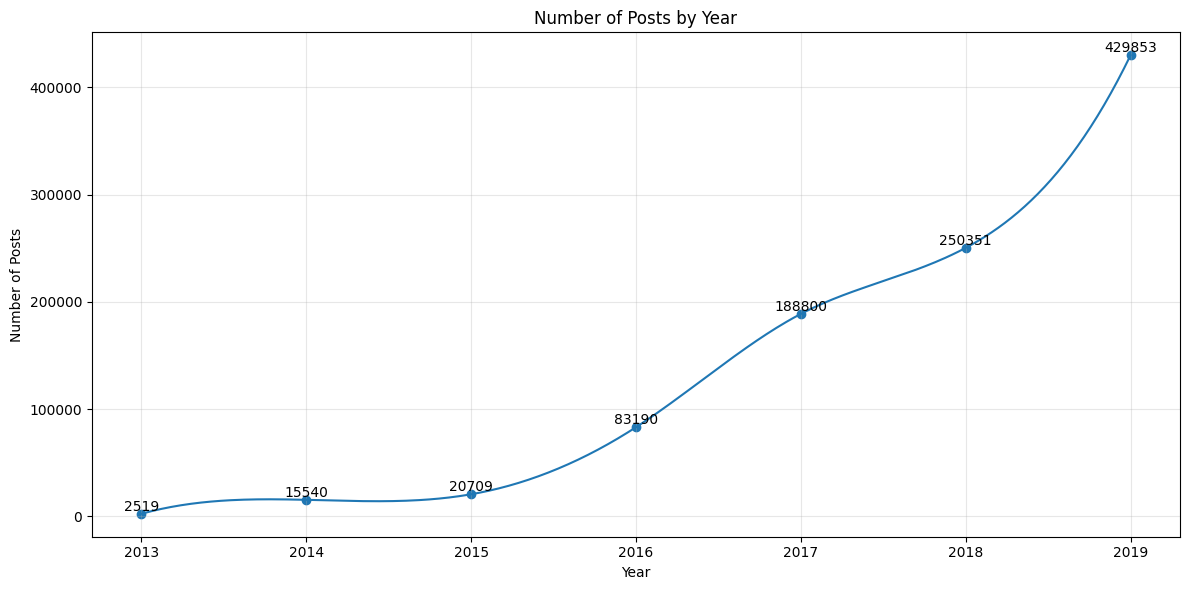

In [161]:
# Group by year and count
yearly_counts = combined_df['YEAR'].value_counts().sort_index()

# Create the plot

plt.figure(figsize=(12, 6))

# Create smooth curve
x = yearly_counts.index
y = yearly_counts.values
xnew = np.linspace(min(x), max(x), 300)
spl = make_interp_spline(x, y, k=3)
smooth = spl(xnew)

# Plot smooth curve and points
plt.plot(xnew, smooth, '-')
plt.scatter(x, y, marker='o')

plt.title('Number of Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True, alpha=0.3)

# Add value labels at each point
for i, j in zip(x, y):
    plt.text(i, j, str(int(j)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Number of Posts by Month (2016-2019)

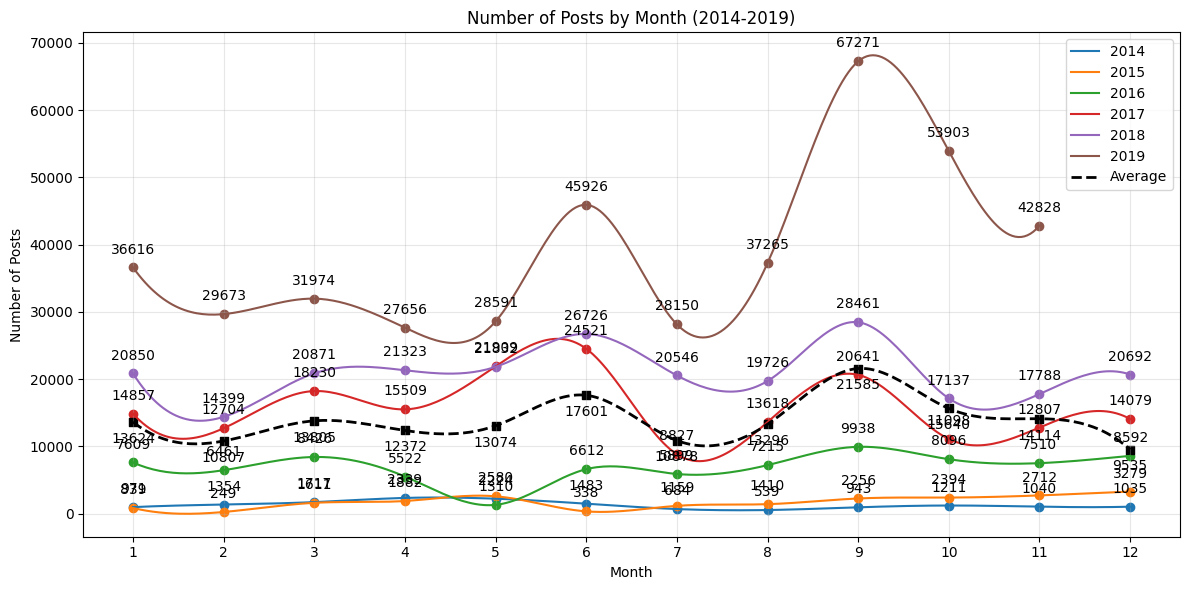

In [162]:
# Extract month and year from DATE
combined_df['Month'] = pd.to_datetime(combined_df['DATE']).dt.month
combined_df['Year'] = pd.to_datetime(combined_df['DATE']).dt.year

# Filter for years 2016-2019
df_2016_2019 = combined_df[(combined_df['Year'] >= 2014) & (combined_df['Year'] <= 2019)]

# Group by year and month, count posts
monthly_counts = df_2016_2019.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Calculate average by month across years
monthly_avg = monthly_counts.groupby('Month')['Count'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))

# Plot lines and points for each year
for year in monthly_counts['Year'].unique():
    year_data = monthly_counts[monthly_counts['Year'] == year]
    x = year_data['Month']
    y = year_data['Count']
    
    # Plot smoothed line
    xnew = np.linspace(min(x), max(x), 300)
    spl = make_interp_spline(x, y, k=3)
    smooth = spl(xnew)
    plt.plot(xnew, smooth, '-', label=str(int(year)))
    
    # Plot actual data points and values
    plt.scatter(x, y, marker='o')
    for i, txt in enumerate(y):
        plt.annotate(int(txt), (x.iloc[i], y.iloc[i]), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Plot average line with points
x_avg = monthly_avg['Month']
y_avg = monthly_avg['Count']

# Plot smoothed average line
xnew_avg = np.linspace(min(x_avg), max(x_avg), 300)
spl_avg = make_interp_spline(x_avg, y_avg, k=3)
smooth_avg = spl_avg(xnew_avg)
plt.plot(xnew_avg, smooth_avg, '--', label='Average', linewidth=2, color='black')

# Plot average data points and values
plt.scatter(x_avg, y_avg, color='black', marker='s')
for i, txt in enumerate(y_avg):
    plt.annotate(f'{txt:.0f}', (x_avg.iloc[i], y_avg.iloc[i]), 
                textcoords="offset points", 
                xytext=(0,-15), 
                ha='center',
                color='black')

plt.title('Number of Posts by Month (2014-2019)')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid(True, alpha=0.3)
plt.legend()

# Set x-axis ticks to show all months
plt.xticks(range(1,13))

plt.tight_layout()
plt.show()


#### Number of Posts by Month (2014-2019) - Stacked together 3 Dimensions

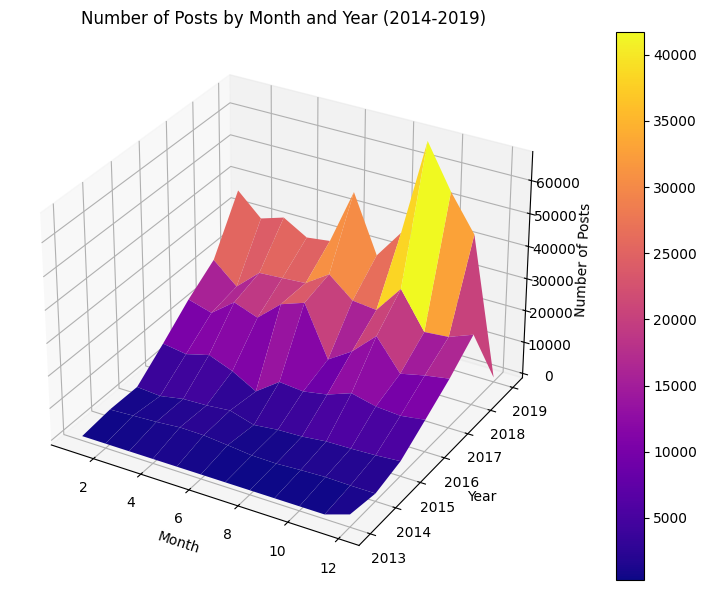

In [166]:
# Create a 3D plot
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Get unique years
years = sorted(combined_df['Year'].unique())
months = range(1, 13)

# Create meshgrid for X (months) and Y (years)
X, Y = np.meshgrid(months, years)
Z = np.zeros_like(X, dtype=float)

# Fill Z values
for i, year in enumerate(years):
    year_data = combined_df[combined_df['Year'] == year]
    for j, month in enumerate(months):
        count = len(year_data[year_data['Month'] == month])
        Z[i,j] = count

# Create the surface plot
surf = ax.plot_surface(X, Y, Z, cmap='plasma')

# Customize the plot
ax.set_xlabel('Month')
ax.set_ylabel('Year')
ax.set_zlabel('Number of Posts')
ax.set_title('Number of Posts by Month and Year (2014-2019)')

# Add a color bar
fig.colorbar(surf)

plt.tight_layout()
plt.show()


#### Number of GSM-related Posts by Year (2013-2019, 2024)

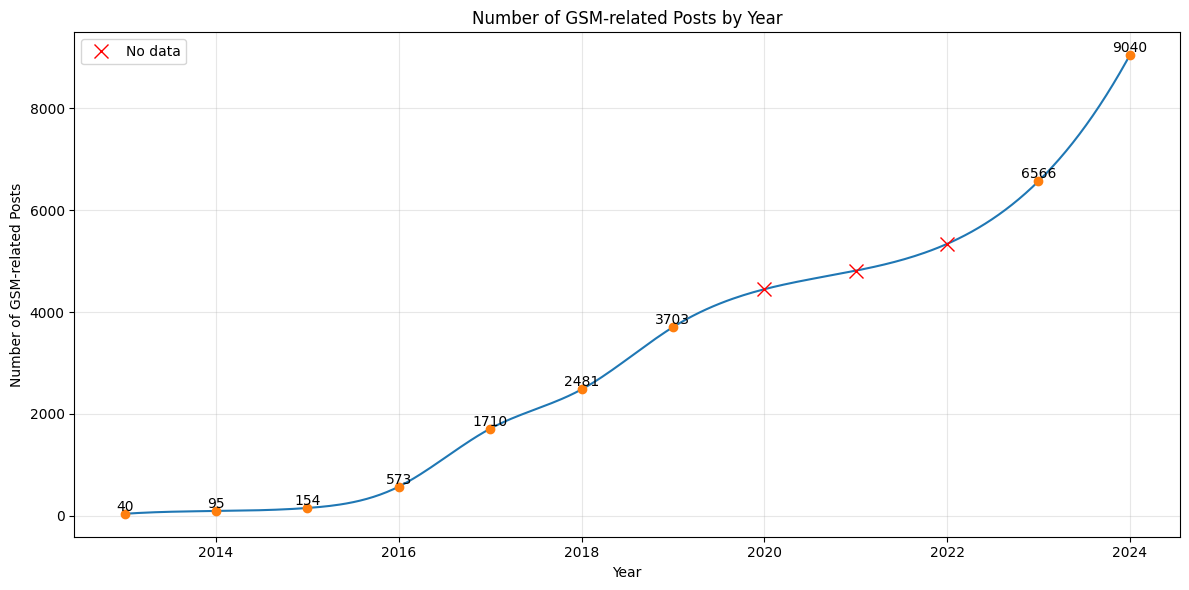

In [171]:
# Group by year and count
yearly_counts = gsm_final_df['YEAR'].value_counts().sort_index()

plt.figure(figsize=(12, 6))

# Create smooth curve
x = yearly_counts.index.astype(float)
y = yearly_counts.values
x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(x_smooth)

# Plot smooth curve and points
plt.plot(x_smooth, y_smooth, '-')
plt.plot(x, y, 'o')

# Add 'x' markers on the curve for years without data
all_years = np.arange(x.min(), x.max() + 1)
missing_years = [year for year in all_years if year not in x]
# For each missing year, find the corresponding y value on the smooth curve
missing_y = spl(missing_years)
plt.plot(missing_years, missing_y, 'rx', markersize=10, label='No data')

plt.title('Number of GSM-related Posts by Year')
plt.xlabel('Year')
plt.ylabel('Number of GSM-related Posts')
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels at each point
for x_val, y_val in zip(yearly_counts.index, yearly_counts.values):
    plt.text(x_val, y_val, str(int(y_val)), ha='center', va='bottom')

plt.tight_layout()
plt.show()